In [6]:
import pandas as pd
import numpy as np
import json
import datetime
import emoji

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob

pd.options.display.max_rows = 200

sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

# 1. Load venmo data

In [7]:
# Load all data
csvs = glob.glob('/gh/data/personal-data-requests/venmo/*.csv')
dfs = []
for csv in csvs:
    df_temp = pd.read_csv(csv)
    # Drop columns that are not columns cause venmo doesn't know how to structure data
    df_temp = df_temp.drop([' Username', 'Beginning Balance', 'Ending Balance',
                            'Statement Period Venmo Fees', 'Year to Date Venmo Fees', 'Disclaimer'], axis=1)
    
    # Drop columns with no real information
    df_temp = df_temp.drop(['ID', 'Status', 'Destination', 'Amount (fee)'], axis=1)
    dfs.append(df_temp)
df = pd.concat(dfs).drop_duplicates().dropna(how='all', axis=0)

# Make better columns
df['dt'] = pd.to_datetime(df['Datetime'])
df['amount'] = np.array([x[3:].replace(',', '') for x in df['Amount (total)']]).astype(float)
df.drop(['Datetime', 'Amount (total)'], axis=1, inplace=True)

# Remove Standard transfers
df_standard_transfer = df[df['Type']=='Standard Transfer'].sort_values(by='dt')
df = df[df['Type']!='Standard Transfer'].reset_index(drop=True)
df['to_me_v1'] = np.logical_and(df['To'] == 'Scott Cole', df['Type'] == 'Payment')
df['to_me_v2'] = np.logical_and(df['From'] == 'Scott Cole', df['Type'] == 'Charge')
df['to_me'] = df['to_me_v1'] + df['to_me_v2']
df['me'] = df['to_me'].map({True: 'To me', False: 'From me'})
df.drop(['to_me_v1', 'to_me', 'to_me_v2'], axis=1, inplace=True)

# Remove outliers
df = df[df['amount'] < 1000].reset_index(drop=True)

df.loc[[557]]

/Users/scott/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,Type,Note,From,To,Funding Source,dt,amount,me
557,Payment,🐷🐷,Richard Gao,Scott Cole,NaN,2018-08-21 02:29:21,29.0,To me


# 2. Plot money to/from me by month

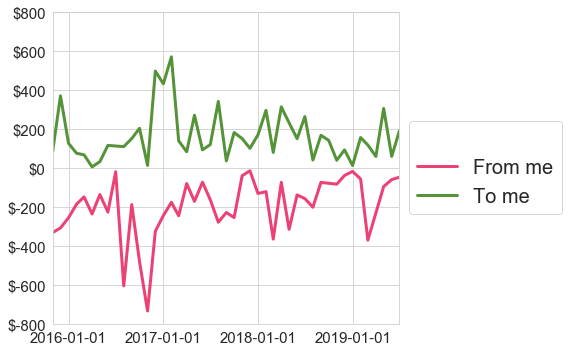

In [8]:
import matplotlib.ticker as ticker

df_plt = df.copy()
df_plt['month'] = pd.to_datetime(df_plt['dt'].dt.strftime('%m/%Y'))
df_plt = df_plt.groupby(['month', 'me'])['amount'].sum().reset_index()
df_plt.loc[df_plt['me']=='From me', 'amount'] = -df_plt.loc[df_plt['me']=='From me', 'amount']

plt.figure(figsize=(8,5))
sns.lineplot(x='month', y='amount', hue='me', data=df_plt, linewidth=3,
             palette=sns.diverging_palette(h_neg=0, h_pos=120, s=80, l=55, n=2))
plt.xlabel('')
plt.ylabel('')
leg = plt.legend(loc='center left', bbox_to_anchor=(1,.5), fontsize=20)
plt.xticks([datetime.datetime(x, 1, 1) for x in range(2016, 2020)])
plt.xlim(datetime.datetime(2015,11,1), datetime.datetime(2019,7,1))

plt.ylim(-800, 800)
leg.texts[0].set_text(None)
for line in leg.get_lines():
    line.set_linewidth(3)

# dollar ticks
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/venmo_transaction_accounts.png')

# 3. Plot distributions of words in notes

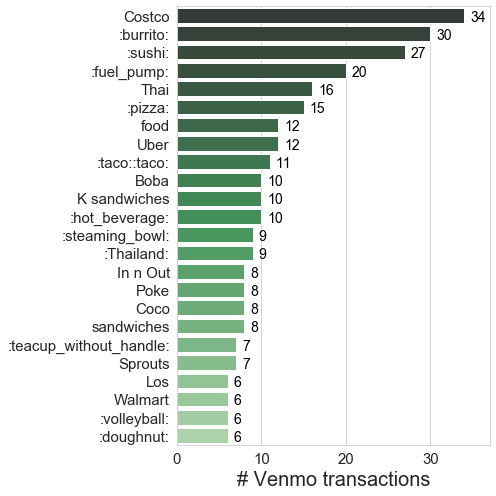

In [17]:
# Prep data to plot
n_min = 6
df_plt = df.copy()
df_plt['note_text'] = [emoji.demojize(x) for x in df_plt['Note']]
df_plt.replace({'K': 'K sandwiches', 'Coco': 'Costco'}, inplace=True)
all_venmo_notes_text = ' '.join(df_plt['note_text'])
pd_word_counts = pd.Series(all_venmo_notes_text.replace('+', ' ').split(' '))
pd_word_counts = pd_word_counts.value_counts().reset_index().rename(columns={'index': 'note', 0: 'count'})
df_plt = pd_word_counts[pd_word_counts['count'] >= n_min]

# reformat
df_plt = df_plt.replace('In', 'In n Out').replace('K', 'K sandwiches')
df_plt = df_plt[~df_plt['note'].isin(['', 'of', 'out', 'and'])].reset_index(drop=True)

# Plot bars
plt.figure(figsize=(7,7))
g=sns.barplot(x='count', y='note', data=df_plt,
              palette=sns.color_palette('Greens_d', n_colors=len(df_plt)))

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=row['count'] + .7,
           y=index + .3,
           s=row['count'],
           color='black',
           ha="left",
           size=14)

plt.ylabel('')
plt.xlabel('# Venmo transactions')
plt.xlim((0,37))
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/venmo_note_counts.png')

# Wordcloud of transactions

(-0.5, 471.5, 459.5, -0.5)

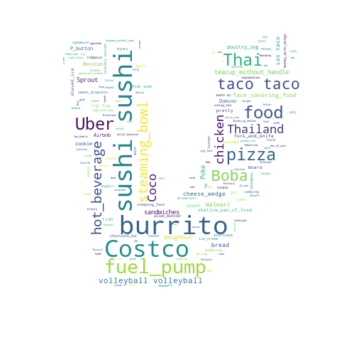

In [10]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# generate word cloud without stopwords
stopwords = set(list(STOPWORDS) + [])
wc = WordCloud(background_color="white", max_words=400, width=1000, height=1000,
               stopwords=stopwords, mask=np.array(Image.open('venmo_mask2.png')))
wc.generate(all_venmo_notes_text)

# store to file
wc.to_file('/gh/srcole.github.io/assets/personaldata/venmo_wordcloud.png')

# show
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")